In [ ]:
from google.colab import drive
drive.mount('/content/drive')

# Работа с изображениями

In [ ]:
import matplotlib.pyplot as plt


def check_images(image_set, label_set, class_label):
  plt.figure(figsize=(16,12))
  for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(image_set[i])
    plt.title(class_label[tf.argmax(label_set[i])])

    plt.axis("off")


# Загрузка датасета

Пути к датасету


In [ ]:
import os

dir_google_drive = "/content/drive/MyDrive/dataset"
train_data = "images_train_test_val/train"
test_data = "images_train_test_val/test"
valid_data = "images_train_test_val/validation"

dir_train_data = os.path.join(dir_google_drive, train_data)
dir_test_data = os.path.join(dir_google_drive, test_data)
dir_valid_data = os.path.join(dir_google_drive, valid_data)

Задаём параметры аугментации

In [ ]:
import tensorflow as tf

train_gen = tf.keras.preprocessing.image.ImageDataGenerator(
    rescale = 1/255.,       # коэффициент масштабирования
    #shear_range = 0.2,      # Интенсивность сдвига
    #zoom_range = 0.2,       # Диапазон случайного увеличения
    #horizontal_flip = True  # Произвольный поворот по горизонтали
    )

test_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.)
val_gen = tf.keras.preprocessing.image.ImageDataGenerator(rescale = 1/255.)

Предобработка выборки

In [ ]:
param = dict(
    target_size = (224,224),
    class_mode = "categorical",
    batch_size = 32
    )

train_data = train_gen.flow_from_directory(dir_train_data,**param)
test_data = test_gen.flow_from_directory(dir_test_data,**param)
val_data = val_gen.flow_from_directory(dir_valid_data,**param)

train_eff = tf.keras.preprocessing.image_dataset_from_directory(dir_train_data, **param)

Found 7350 images belonging to 21 classes.
Found 1050 images belonging to 21 classes.
Found 2100 images belonging to 21 classes.


Проверяем выборку

In [ ]:
class_label = list(train_data.class_indices.keys())
image_set, label_set = train_data.next()

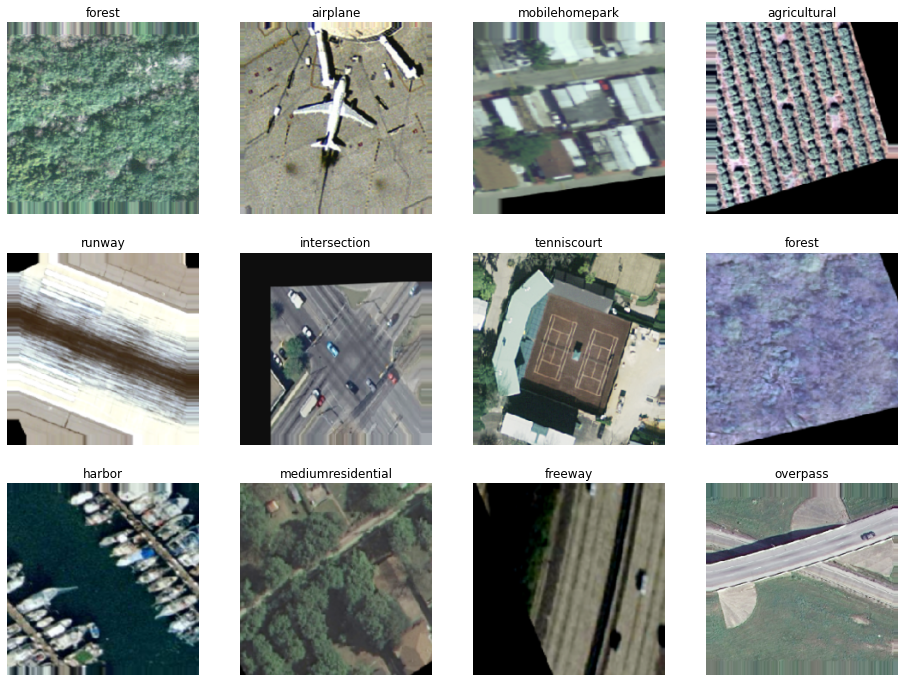

In [ ]:
check_images(image_set, label_set, class_label)

In [ ]:
from tensorflow.keras import layers

model = tf.keras.Sequential([
                             layers.Conv2D(filters= 32, kernel_size= 2, activation="relu", input_shape=(224,224,3)),
                             layers.MaxPooling2D(pool_size= 2),

                             layers.Conv2D(filters = 32, kernel_size= 2, activation="relu"),
                             layers.MaxPooling2D(pool_size= 2),

                             layers.Conv2D(filters= 32, kernel_size= 2, activation= "relu"),
                             layers.MaxPooling2D(pool_size=2),

                             layers.Conv2D(filters= 32, kernel_size= 2, activation= "relu"),
                             layers.MaxPooling2D(pool_size=2),

                            
                             layers.Conv2D(filters= 32, kernel_size= 2, activation= "relu"),
                             layers.Conv2D(filters= 32, kernel_size= 2, activation= "relu"),
                             layers.Conv2D(filters= 32, kernel_size= 2, activation= "relu"),

                             layers.Flatten(),

                             layers.Dense(256, activation="relu"),

                             layers.Dense(21, activation="softmax")


])

In [ ]:
model.compile(
    loss = tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
    metrics = ["accuracy"]
)

In [ ]:
epochs = 10
testing_steps = len(train_data)
validation_steps = len(val_data)

In [ ]:
model.fit(
    train_data,
    epochs = epochs,
    steps_per_epoch = testing_steps,
    validation_data = val_data,
    validation_steps = validation_steps
)

Epoch 1/10
230/230 [==============================] - ETA: 0s - loss: 2.6982 - accuracy: 0.1371

KeyboardInterrupt: ignored

In [ ]:
model_evaluation = model.evaluate(test_data)

33/33 [==============================] - 268s 8s/step - loss: 1.3317 - accuracy: 0.5514


In [ ]:
print(f"Model Accuarcy: {model_evaluation[1] * 100: 0.2f} %")

Model Accuarcy:  55.14 %


In [ ]:
eff_base = tf.keras.applications.EfficientNetB5(include_top= False)

eff_base.trainable = False

115277824/115263384 [==============================] - 3s 0us/step


In [ ]:
from tensorflow.keras import layers
train_eff = tf.keras.preprocessing.image_dataset_from_directory(dir_train_data,
                                                                     label_mode = "categorical",
                                                                     image_size = (224,224),
                                                                     batch_size = 32
                                                                    
                                                                     )

test_eff = tf.keras.preprocessing.image_dataset_from_directory(dir_test_data,
                                                                   label_mode = "categorical",
                                                                   image_size = (224,224),
                                                                   batch_size = 32
                                                                   
                                                                   )
val_eff = tf.keras.preprocessing.image_dataset_from_directory(dir_valid_data,
                                                                   label_mode = "categorical",
                                                                   image_size = (224,224),
                                                                   batch_size = 32
                                                                   
                                                                   )
inputs = tf.keras.Input(shape=(224,224,3))

x = eff_base(inputs)

x = layers.GlobalAveragePooling2D()(x)

outputs = layers.Dense(21, activation="softmax")(x)

eff_model = tf.keras.Model(inputs, outputs)

eff_model.compile(
    loss = tf.keras.losses.categorical_crossentropy,
    optimizer = tf.keras.optimizers.Adam(learning_rate= 0.001),
    metrics = ["accuracy"]
)

history = eff_model.fit( train_eff,
             epochs = 5,
             steps_per_epoch = len(train_eff),
             validation_data = val_eff,
             validation_steps = len(val_eff)
             )

Found 7350 files belonging to 21 classes.
Found 1050 files belonging to 21 classes.
Found 2100 files belonging to 21 classes.
Epoch 1/5
230/230 [==============================] - 3006s 13s/step - loss: 0.8682 - accuracy: 0.8155 - val_loss: 0.3831 - val_accuracy: 0.9110
Epoch 2/5
230/230 [==============================] - 66s 281ms/step - loss: 0.2899 - accuracy: 0.9352 - val_loss: 0.2580 - val_accuracy: 0.9367
Epoch 3/5
230/230 [==============================] - 67s 288ms/step - loss: 0.1989 - accuracy: 0.9550 - val_loss: 0.2071 - val_accuracy: 0.9452
Epoch 4/5
230/230 [==============================] - 68s 290ms/step - loss: 0.1550 - accuracy: 0.9668 - val_loss: 0.1741 - val_accuracy: 0.9533
Epoch 5/5
230/230 [==============================] - 68s 290ms/step - loss: 0.1258 - accuracy: 0.9735 - val_loss: 0.1535 - val_accuracy: 0.9590


# Работа с моделью

Библиотеки

In [ ]:
import numpy as np

Сохранение и загрузка модели

In [ ]:
def save_weights(model, path, name):
  model.save_weights(os.path.join(path, name))

def load_weights(model, path, name):
  model.load_weights(os.path.join(path, name))

def save_model(model, path):
  model.save(path)
  np.save(os.path.join(path,'history.npy'), model.history)

def load_model(path):
  return tf.keras.models.load_model(path), np.load(os.path.join(path,'history.npy'),allow_pickle='TRUE').item()

In [ ]:
save_model(eff_model, '/content/drive/MyDrive/Model_1')

INFO:tensorflow:Assets written to: ram://0f72579c-a943-4506-8100-4e065b280597/assets
INFO:tensorflow:Assets written to: /content/drive/MyDrive/Model_1/assets
INFO:tensorflow:Assets written to: ram://3ff83e31-0f84-4eb3-a557-647b93238365/assets


In [ ]:
model_test, history_1 = load_model('/content/drive/MyDrive/Model_1')

# Графики

In [ ]:
def show_final_history(history):
    
    plt.style.use("ggplot")
    fig, ax = plt.subplots(1,2,figsize=(15,5))
    
    ax[0].set_title('Loss')
    ax[1].set_title('Accuracy')
    
    ax[0].plot(history.history['loss'], label="Training Loss")
    ax[0].plot(history.history['val_loss'], label="Validation Loss")
    ax[1].plot(history.history['accuracy'], label="Training Accuracy")
    ax[1].plot(history.history['val_accuracy'], label="Validation Accuracy")
    
    ax[0].legend(loc='upper right')
    ax[1].legend(loc='lower right')
    
    plt.show();
    pass

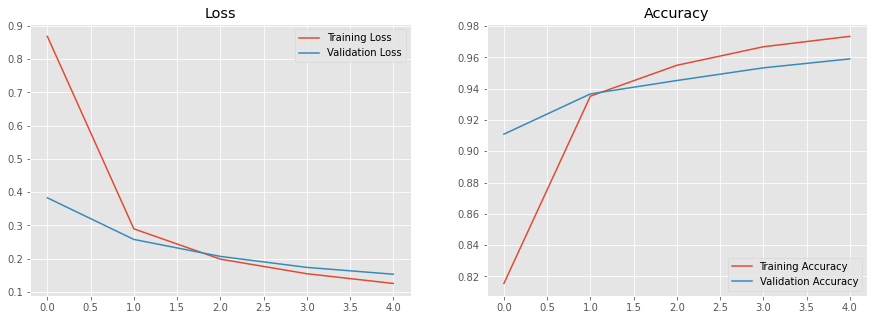

In [ ]:

#print(eff_model.history)
show_final_history(history_1)